# Intro to Keras

## Outline
1. Fully-connected network for MNIST classification
2. Callbacks
3. Saving and restoring a trained model
4. Batch-normalization
5. Regularization
6. Predictions and error analysis
7. Resources

In [1]:
# Import modules
import os
import sys
import numpy as np
import pandas as pd
import random as rn

from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt

print('Python working path: {}'.format(sys.executable))

Python working path: /Users/apartin/anaconda/envs/py35_tf14/bin/python


In [2]:
# Import DL modules
import tensorflow as tf
import keras
print('TensorFlow version: {}'.format(tf.__version__))
print('Keras version: {}'.format(keras.__version__))

Using TensorFlow backend.


TensorFlow version: 1.4.0
Keras version: 2.1.2


In [3]:
# Import Keras methods
from keras import backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, BatchNormalization, Dropout
from keras import optimizers, losses, regularizers
from keras import callbacks
from keras.utils import to_categorical
from keras.datasets import mnist, fashion_mnist, boston_housing

In [4]:
seed = 2018
np.random.seed(seed)
rn.seed(seed)

# 1. Fully-connected network for MNIST classification

## Action plan
General steps for training and evaluationg a neural network in Keras:
1. Prepare the data (get the data ready to be fed into a neural network)
2. Create the model (define a neural network architecture)
3. Compile the model (define the loss function and the optimizer)
4. Train the model (train the network on the training set)
5. Evaluate the model (on val/test data)

The MNIST database (Modified National Institute of Standards and Technology) is an annotated (labeled) dataset of gray-scale images of handwritten digits. The digits are size-normalized (28 x 28 pixels) and centered. The dataset contain 60,000 training images and 10,000 test images.

- http://yann.lecun.com/exdb/mnist/
- https://en.wikipedia.org/wiki/MNIST_database

In [5]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [6]:
# Print shapes and type
print('train_images: {}, {}'.format(train_images.shape, train_images.dtype))
print('test_images:  {}, {}'.format(test_images.shape, test_images.dtype))
print('\ntrain_labels: {}, {}'.format(train_labels.shape, train_labels.dtype))
print('test_labels:  {}, {}'.format(test_labels.shape, test_labels.dtype))

train_images: (60000, 28, 28), uint8
test_images:  (10000, 28, 28), uint8

train_labels: (60000,), uint8
test_labels:  (10000,), uint8


In [7]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [8]:
def show_mnist_images(images, titles=None):
    """Plot random mnist images."""
    f, ax = plt.subplots(1, len(images), figsize=(12, 4))
    for i in range(len(images)):
        ax[i].imshow(images[i].reshape(28, 28), cmap='gray')  # cmap=plt.cm.binary
        if titles is not None:
            ax[i].set_title('{}'.format(titles[i]), fontsize=25)

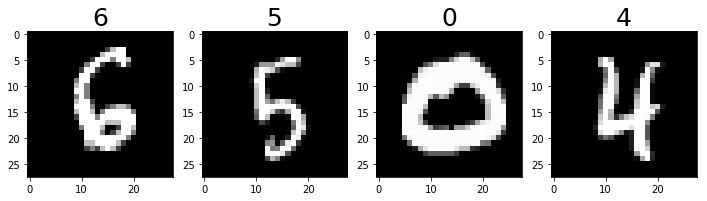

In [9]:
n_images = 4
inds = np.random.randint(low=0, high=len(train_images), size=n_images)
show_mnist_images(images = train_images[inds],
                  titles = train_labels[inds])

In [10]:
# Display python function
show_mnist_images??

In [11]:
# Reshape images for fully-connected input layer
train_images = train_images.reshape((60000, 28 * 28))
test_images  = test_images.reshape((10000, 28 * 28))

In [12]:
# Split training data into training and validation data
val_size = 0.2
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels,
                                                                      test_size=val_size, random_state=seed,
                                                                      shuffle=True)

### Check that the training and validation datasets are balanced

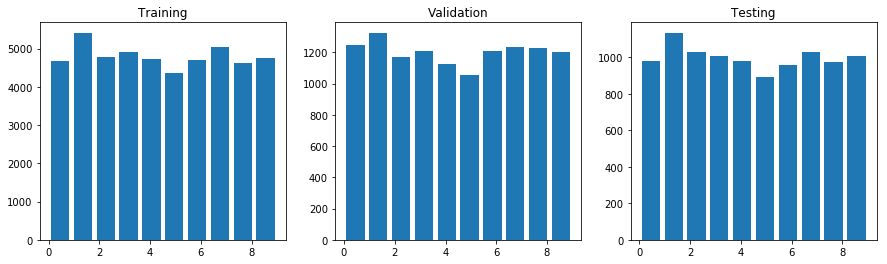

In [13]:
f, ax = plt.subplots(1, 3, figsize=(15,4))
ax[0].hist(train_labels, rwidth=0.8); ax[0].set_title('Training')
ax[1].hist(val_labels, rwidth=0.8);   ax[1].set_title('Validation')
ax[2].hist(test_labels, rwidth=0.8);  ax[2].set_title('Testing')

In [14]:
# One-hot encode the target variable
train_labels_onehot = to_categorical(train_labels)
val_labels_onehot   = to_categorical(val_labels)
test_labels_onehot  = to_categorical(test_labels)

In [15]:
print(train_labels_onehot)

print('\nOne-hot label of a single image:')
print(train_labels_onehot[0,:])

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  1.  0.  0.]
 ..., 
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]

One-hot label of a single image:
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


In [16]:
# Print dataset after reshaping
print('train_images: {}, {}'.format(train_images.shape, train_images.dtype))
print('val_images:   {}, {}'.format(val_images.shape, val_images.dtype))
print('test_images:  {}, {}'.format(test_images.shape, test_images.dtype))

print('\ntrain_labels: {}, {}'.format(train_labels_onehot.shape, train_labels_onehot.dtype))
print('val_labels:   {}, {}'.format(val_labels_onehot.shape, val_labels_onehot.dtype))
print('test_labels:  {}, {}'.format(test_labels_onehot.shape, test_labels_onehot.dtype))

train_images: (48000, 784), uint8
val_images:   (12000, 784), uint8
test_images:  (10000, 784), uint8

train_labels: (48000, 10), float64
val_labels:   (12000, 10), float64
test_labels:  (10000, 10), float64


In [17]:
# Pre-process the data (convert to float and scale)
train_images = train_images.astype('float32') / 255
val_images   = val_images.astype('float32') / 255
test_images  = test_images.astype('float32') / 255

### Define the model (neural network architecture)

- Input layer has 784 input units as the total number of pixels in a single MNIST image (28 x 28)
- Two hidden layers, each with 128 neurons
- Output layer has 10 units as the number of classes [0,1,2,3,4,5,6,7,8,9]
- $a^{l}_{j}$ is the activation of layer $l$ and neuron $j$

<img src="figures/mnist_classifier.png", width=50%>

In [18]:
def create_mnist_classifier(activation='relu'):
    """Create an MNIST classier."""
    model = Sequential()
    model.add(Dense(units=128, activation=activation, input_shape=(28 * 28,)))  # 784 * 128 + 128 = 100480
    model.add(Dense(units=128, activation=activation))  # 128 * 128 + 128 = 16512
    model.add(Dense(units=10, activation='softmax'))  # 128 * 10 + 10 = 1290
    return model

In [19]:
model = create_mnist_classifier()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [21]:
# Train the model
history = model.fit(x = train_images,
                    y = train_labels_onehot,
                    batch_size = 128,
                    epochs = 5,
                    validation_data = (val_images, val_labels_onehot),
                    shuffle = True)  # randomly shuffles the training data for every new epoch

Train on 48000 samples, validate on 12000 samples
Epoch 1/5
48000/48000 [==============================] - 2s 35us/step - loss: 0.3331 - acc: 0.9031 - val_loss: 0.1816 - val_acc: 0.9452
Epoch 2/5
48000/48000 [==============================] - 1s 28us/step - loss: 0.1439 - acc: 0.9572 - val_loss: 0.1128 - val_acc: 0.9658
Epoch 3/5
48000/48000 [==============================] - 1s 26us/step - loss: 0.1002 - acc: 0.9694 - val_loss: 0.1019 - val_acc: 0.9699
Epoch 4/5
48000/48000 [==============================] - 1s 26us/step - loss: 0.0758 - acc: 0.9768 - val_loss: 0.0943 - val_acc: 0.9727
Epoch 5/5
48000/48000 [==============================] - 1s 26us/step - loss: 0.0601 - acc: 0.9814 - val_loss: 0.0848 - val_acc: 0.9748


In [22]:
# Evaluate the model on the training data
train_loss, train_acc = model.evaluate(x = train_images,
                                       y = train_labels_onehot)

print('train_loss: {}'.format(train_loss))
print('train_acc: {}'.format(train_acc))

48000/48000 [==============================] - 1s 27us/step
train_loss: 0.043535624450732335
train_acc: 0.9866666666666667


In [23]:
# Evaluate the model on the validation data
val_loss, val_acc = model.evaluate(x = val_images,
                                   y = val_labels_onehot)

print('val_loss: {}'.format(val_loss))
print('val_acc: {}'.format(val_acc))

12000/12000 [==============================] - 0s 28us/step
val_loss: 0.08480773801620428
val_acc: 0.97475


Take a look at the following metrics:
- Training metrics (`loss` and `acc`) and the validation metrics (`val_loss` and `val_acc`) printed at the last training epoch
- Training metrics (`train_loss` and `train_acc`) and the validation metrics (`val_loss` and `val_acc`) computed using the `evaluate` method after the training has been completed
<br/>

Notice that the validation values do match, while the training values do not. The reason is that `val_loss` and `val_acc` are computed using the most updated neural network model at the end of every epoch. On the other hand, `loss` and `acc` (i.e., loss and acc for the training set) are the average values across all the batches for a given epoch. 

In [24]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(x = test_images,
                                     y = test_labels_onehot)

print('test_loss: {}'.format(test_loss))
print('test_acc: {}'.format(test_acc))

10000/10000 [==============================] - 0s 30us/step
test_loss: 0.08083164437315427
test_acc: 0.9751


In [25]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [26]:
def plot_training(history):
    epochs = np.asarray(history.epoch) + 1
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.plot(epochs, loss, 'bo', label='loss')
    plt.plot(epochs, val_loss, 'ro', label='val_loss')
    plt.grid('on')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.xlim(0, len(epochs)+1)
    plt.ylim(0.0, 0.5)

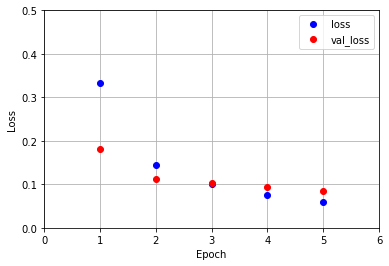

In [27]:
plot_training(history)

# 2. Callbacks

- Keras callbacks: https://keras.io/callbacks/
- A callback is a set of functions that can be applied at given stages of the training procedure. You can pass a list of callbacks to the .fit() method of the model.

In [28]:
model = create_mnist_classifier()

model.compile(optimizer = optimizers.RMSprop(lr=0.001),  # or 'rmsprop'
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [29]:
callbacks_list = [
#     callbacks.EarlyStopping(monitor = 'val_loss',
#                             min_delta = 0.001,
#                             patience = 1),

#     callbacks.ModelCheckpoint(filepath = filepath,
#                               monitor = 'val_loss',
#                               save_best_only = True,
#                               period = 1),
    
    callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                factor = 0.1,
                                patience = 1,
                                verbose = 1),
    
    callbacks.CSVLogger(filename='training.log', separator=',', append=False)
]


In [30]:
# Train the model
history = model.fit(x = train_images,
                    y = train_labels_onehot,
                    batch_size = 128,
                    epochs = 12,
                    validation_data = (val_images, val_labels_onehot),
                    callbacks = callbacks_list,
                    shuffle = True)

Train on 48000 samples, validate on 12000 samples
Epoch 1/12
48000/48000 [==============================] - 2s 38us/step - loss: 0.3368 - acc: 0.9038 - val_loss: 0.1764 - val_acc: 0.9488
Epoch 2/12
48000/48000 [==============================] - 1s 29us/step - loss: 0.1459 - acc: 0.9563 - val_loss: 0.1243 - val_acc: 0.9628
Epoch 3/12
48000/48000 [==============================] - 1s 29us/step - loss: 0.0995 - acc: 0.9694 - val_loss: 0.1073 - val_acc: 0.9674
Epoch 4/12
48000/48000 [==============================] - 1s 29us/step - loss: 0.0735 - acc: 0.9772 - val_loss: 0.0937 - val_acc: 0.9728
Epoch 5/12
48000/48000 [==============================] - 1s 29us/step - loss: 0.0588 - acc: 0.9816 - val_loss: 0.0896 - val_acc: 0.9748
Epoch 6/12
48000/48000 [==============================] - 1s 30us/step - loss: 0.0460 - acc: 0.9854 - val_loss: 0.0869 - val_acc: 0.9756
Epoch 7/12
48000/48000 [==============================] - 1s 30us/step - loss: 0.0376 - acc: 0.9886 - val_loss: 0.0817 - val_acc

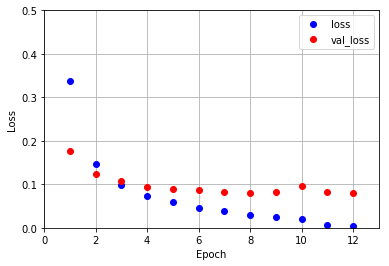

In [31]:
plot_training(history)

# 3. Saving and restoring a trained model

Keras FAQ: https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model

In [32]:
test_loss, test_acc = model.evaluate(x = test_images,
                                     y = test_labels_onehot)

print('test_loss: {}'.format(test_loss))
print('test_acc: {}'.format(test_acc))

10000/10000 [==============================] - 0s 30us/step
test_loss: 0.07843357847087919
test_acc: 0.9805


In [33]:
# Save the model
model_name = 'my_model.h5'
model.save(model_name)

In [34]:
# Delete the model
del model

In [35]:
# Load the model
if os.path.exists(model_name):
    model = load_model('my_model.h5')
else:
    print('The model was not found.')

In [36]:
test_loss, test_acc = model.evaluate(x = test_images,
                                     y = test_labels_onehot)

print('test_loss: {}'.format(test_loss))
print('test_acc: {}'.format(test_acc))

10000/10000 [==============================] - 0s 31us/step
test_loss: 0.07843357847087919
test_acc: 0.9805


In [37]:
# Note that training.log file is overwritten
# Note that there is no need to compile the model
history = model.fit(x = train_images,
                    y = train_labels_onehot,
                    batch_size = 128,
                    epochs = 2,
                    validation_data = (val_images, val_labels_onehot),
                    callbacks = callbacks_list,
                    shuffle = True)

Train on 48000 samples, validate on 12000 samples
Epoch 1/2
48000/48000 [==============================] - 1s 30us/step - loss: 0.0050 - acc: 0.9989 - val_loss: 0.0808 - val_acc: 0.9812
Epoch 2/2
48000/48000 [==============================] - 1s 29us/step - loss: 0.0050 - acc: 0.9990 - val_loss: 0.0808 - val_acc: 0.9812


In [38]:
test_loss, test_acc = model.evaluate(x = test_images,
                                     y = test_labels_onehot)

print('test_loss: {}'.format(test_loss))
print('test_acc:  {}'.format(test_acc))

10000/10000 [==============================] - 0s 29us/step
test_loss: 0.07845008841170348
test_acc:  0.9804


# 4. Batch-normalization (batch-norm)

- Batch-norm is a method for normalizing the mean and variance of layer activations for every mini-batch.
- The original batch-norm paper: https://arxiv.org/abs/1502.03167
- Deep Learning Specialization: https://www.coursera.org/learn/deep-neural-network/home/week/3

In [39]:
model = Sequential()
model.add(Dense(units=64, activation=None, input_shape=(28 * 28,)))
model.add(Activation('relu'))
model.add(Dense(units=10, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
history = model.fit(x=train_images, y=train_labels_onehot,
                    batch_size=128, epochs=2, shuffle=True,
                    validation_data=(val_images, val_labels_onehot))

Train on 48000 samples, validate on 12000 samples
Epoch 1/2
48000/48000 [==============================] - 1s 26us/step - loss: 0.4351 - acc: 0.8832 - val_loss: 0.2528 - val_acc: 0.9303
Epoch 2/2
48000/48000 [==============================] - 1s 20us/step - loss: 0.2186 - acc: 0.9376 - val_loss: 0.1880 - val_acc: 0.9448


In [41]:
test_loss, test_acc = model.evaluate(x = test_images,
                                     y = test_labels_onehot)

print('test_loss: {}'.format(test_loss))
print('test_acc:  {}'.format(test_acc))

10000/10000 [==============================] - 0s 27us/step
test_loss: 0.1845684148401022
test_acc:  0.9452


In [42]:
model_btch = Sequential()
model_btch.add(Dense(units=64, activation=None, input_shape=(28*28,)))
model_btch.add(BatchNormalization())
model_btch.add(Activation('relu'))
model_btch.add(Dense(units=10, activation='softmax'))

model_btch.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [43]:
history = model_btch.fit(x=train_images, y=train_labels_onehot,
                         batch_size=128, epochs=2, shuffle=True,
                         validation_data=(val_images, val_labels_onehot))

Train on 48000 samples, validate on 12000 samples
Epoch 1/2
48000/48000 [==============================] - 2s 41us/step - loss: 0.3747 - acc: 0.9031 - val_loss: 0.1987 - val_acc: 0.9443
Epoch 2/2
48000/48000 [==============================] - 1s 27us/step - loss: 0.1749 - acc: 0.9515 - val_loss: 0.1489 - val_acc: 0.9574


In [44]:
test_loss, test_acc = model_btch.evaluate(x = test_images,
                                          y = test_labels_onehot)

print('test_loss: {}'.format(test_loss))
print('test_acc:  {}'.format(test_acc))

10000/10000 [==============================] - 0s 33us/step
test_loss: 0.14692816766798497
test_acc:  0.9567


# 5. Regularization

Some of the methods to fight overfitting and improving the model generalization:
- Get more data
- Reduce the complexity of the network
- Regularization methods

Deep Learning Specialization: https://www.coursera.org/learn/deep-neural-network/home/week/1

In [45]:
model = Sequential()
model.add(Dense(units=512, activation='relu', input_shape=(28*28,)))
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=10, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
history = model.fit(x=train_images, y=train_labels_onehot, batch_size=128,
                    epochs=10, shuffle=True, verbose=0,
                    validation_data=(val_images, val_labels_onehot))

In [47]:
test_loss, test_acc = model.evaluate(x = test_images,
                                     y = test_labels_onehot)

print('test_loss: {}'.format(test_loss))
print('test_acc:  {}'.format(test_acc))

10000/10000 [==============================] - 1s 53us/step
test_loss: 0.10774337939508159
test_acc:  0.9809


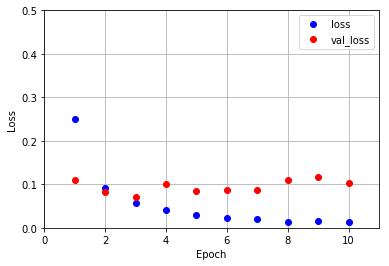

In [48]:
plot_training(history)

## Regularization using Dropout
- The original dropout paper: https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf
- Deep Learning Specialization: https://www.coursera.org/learn/deep-neural-network/home/week/1

- Dropout is a method where randomly selected neurons are "dropped" (ignored) during training.
- The weights of the dropped neurons are not updated for the given mini-batch.
- Note that dropout is applied only in the training phase.
<img src='figures/dropout.png', width=70%>

In [49]:
# In the Keras Dropout layer, the user specifies the fraction of neurons to drop.
model = Sequential()
model.add(Dense(units=512, activation='relu', input_shape=(28*28,)))
model.add(Dropout(0.35))
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=10, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
history = model.fit(x=train_images, y=train_labels_onehot, batch_size=128,
                    epochs=10, shuffle=True, verbose=0,
                    validation_data=(val_images, val_labels_onehot))

In [51]:
test_loss, test_acc = model.evaluate(x = test_images,
                                     y = test_labels_onehot)

print('test_loss: {}'.format(test_loss))
print('test_acc: {}'.format(test_acc))

10000/10000 [==============================] - 1s 56us/step
test_loss: 0.0773944780907008
test_acc: 0.9822


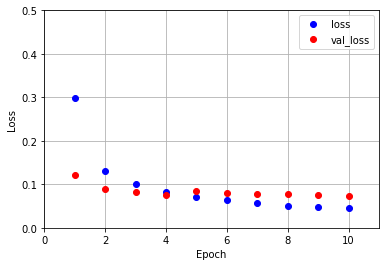

In [52]:
plot_training(history)

# 6. Predictions and error analysis

In [53]:
preds = model.predict(test_images)
print('preds shape:  {}\n'.format(preds.shape))

preds shape:  (10000, 10)



- The predict() method returns a matrix of the following shape:  [number of images, number of classes].
- Each row vector represents prediction probabilities for a given image (sum to 1)
- Each value in the vector is the probability that the input image is of a particular class

[  3.39252743e-17   1.18103867e-12   4.60142680e-08   4.83525639e-07
   1.15265592e-18   3.84354115e-13   6.25346507e-25   9.99999523e-01
   1.09607635e-12   1.08007325e-09]

Sum of predictions for all classes: 1.0


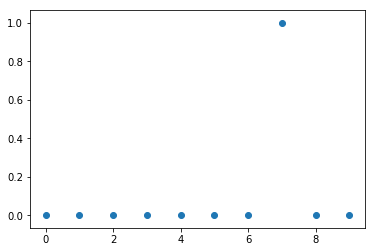

In [54]:
print(preds[0, :])
print('\nSum of predictions for all classes: {}'.format(preds[0, :].sum()))
plt.scatter(np.arange(0, 10), preds[0,:])

In [55]:
pred_classes = model.predict_classes(test_images)  # preds.argmax(axis=1)

print(test_labels)
print(pred_classes)

incorrectly_classified = (pred_classes != test_labels)
print('\nNumber of mis-classified images:  {}'.format(incorrectly_classified.sum()))

[7 2 1 ..., 4 5 6]
[7 2 1 ..., 4 5 6]

Number of mis-classified images:  178


## Error analysis
It is useful to analyze where your model predicted correctly and incorrectly.

### 1. Correctly classdied images

True labels:


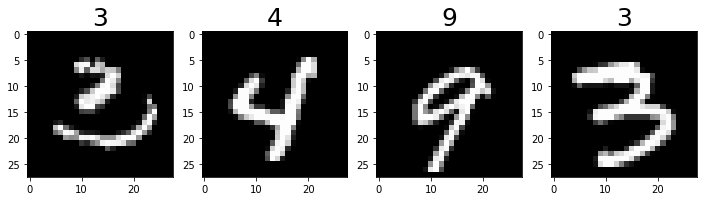

In [56]:
correct = np.where(pred_classes == test_labels)[0]  # get the indices of correctly classified images

n_images = 4
correct_inds = np.random.permutation(correct)[:n_images]

print('True labels:')
show_mnist_images(images = test_images[correct_inds],
                  titles = test_labels[correct_inds])

Predicted labels:


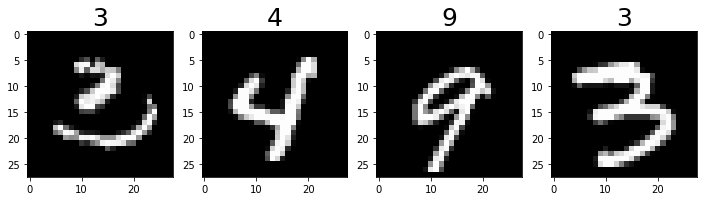

In [57]:
print('Predicted labels:')
show_mnist_images(images = test_images[correct_inds],
                  titles = pred_classes[correct_inds])

### 2. Incorrectly classdied images

True labels:


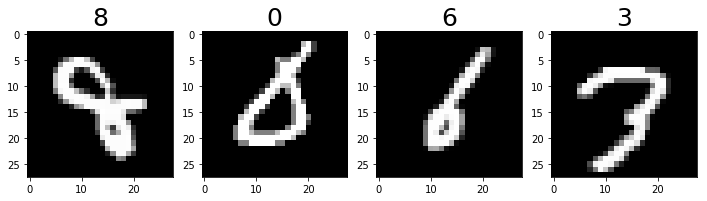

In [58]:
incorrect = np.where(pred_classes != test_labels)[0]  # get the indices of incorrectly classified images

n_images = 4
incorrect_inds = np.random.permutation(incorrect)[:n_images]

print('True labels:')
show_mnist_images(images = test_images[incorrect_inds],
                  titles = test_labels[incorrect_inds])

Predicted labels:


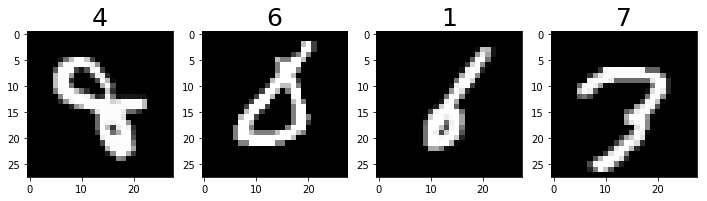

In [59]:
print('Predicted labels:')
show_mnist_images(images = test_images[incorrect_inds],
                  titles = pred_classes[incorrect_inds])

# 7. Resources

- Deep Learning with Python (F. Chollet): https://www.manning.com/books/deep-learning-with-python
- Deep Learning Specialization (Andrew Ng): https://www.coursera.org/specializations/deep-learning
- Stanford course cs231n (Fei-Fei Li): http://cs231n.stanford.edu/
- fast.ai part 1: http://course.fast.ai/
- fast.ai part 2: http://course.fast.ai/part2.html
- fast.ai part 1 (v2, using PyTorch): http://forums.fast.ai/t/welcome-to-part-1-v2/5787
- Data science competitions: https://www.kaggle.com/
- Deep Learning (I. Goodfellow) http://www.deeplearningbook.org/